**This Notebook implements basic SoftMax Logistic Regression on the MNIST dataset using Numpy.**

In [3]:
import numpy as np
import time
import os
import struct
import matplotlib.pyplot as plt
%matplotlib inline

**Run softmax over a simple example with m=4 samples, C=3 classes and n=3 inputs.**

Compute Y = X \* W + b with C classes, n inputs and m samples.

X will have dimensions of (m,n), W of (n,C) and b of (1,C).

X \* W will gives us a matrix of size m \* C which is what we would expect and Y will be size m \* C with one hot encoding.

The m samples will have inputs [0.6,0.3,0.1], [0.3,0.5,0.2], [0.0,0.1,0.9] and [0.1,0.6,0.4] with output classes of 0,1,2,1 respectively. The output class reflects the highest valued input index.


In [4]:
def InitExample():
    X=np.array([[0.6,0.3,0.1],[0.3,0.5,0.2],[0.0,0.1,0.9],[0.1,0.6,0.4]])
    labels=np.array([0,1,2,1])
    Y=np.eye(max(labels)+1)[labels]
    return X, Y, labels

The function InitWeights takes the X and Y matrices as inputs and initializes W and b based on their dimensions.

In [5]:
def InitWeights(X, Y):
    m, n = X.shape
    C = Y.shape[1]
    assert m == Y.shape[0], "X and Y do not have the same number of samples"
    W=np.zeros([n, C])
    b=np.zeros([1, C])
    return W, b

The following two functions compute the score and softmax given X, W and b.

In [6]:
def score(X, W, b):
    return np.dot(X, W) + b

In [7]:
def softmax(scores):
    exp_scores = np.exp(scores)
    s = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return s

Run a test to verify that we have the correct shape for W and b and that softmax is being computed correctly.
Each row of softmax needs to add upto 1 and since W,b are initialized to all zeros, all the values should be the same.

In [8]:
X, Y, labels = InitExample()

print("X:", X)
print("X.shape:", X.shape)
print("Y:", Y)
print("Y.shape:", Y.shape)
print("labels:", labels)
print("labels.shape:", labels.shape)
m, n = X.shape
C = Y.shape[1]
print("n =", n, "m =", m, "C =", C)

W, b = InitWeights(X, Y)
print("W:", W)
print("W.shape:", W.shape)
print("b:", b)
print("b.shape:", b.shape)
softmax(score(X, W, b))

X: [[ 0.6  0.3  0.1]
 [ 0.3  0.5  0.2]
 [ 0.   0.1  0.9]
 [ 0.1  0.6  0.4]]
X.shape: (4, 3)
Y: [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]]
Y.shape: (4, 3)
labels: [0 1 2 1]
labels.shape: (4,)
n = 3 m = 4 C = 3
W: [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
W.shape: (3, 3)
b: [[ 0.  0.  0.]]
b.shape: (1, 3)


array([[ 0.33333333,  0.33333333,  0.33333333],
       [ 0.33333333,  0.33333333,  0.33333333],
       [ 0.33333333,  0.33333333,  0.33333333],
       [ 0.33333333,  0.33333333,  0.33333333]])

The ComputeCost function takes W,X,Y,b as inputs and returns the current softmax probabilities, cost and gradients for W and b.

In [9]:
def ComputeCost(W, X, Y, b):
    m = X.shape[0]
    grads = {}
    prob = softmax(score(X, W, b))
    cost = (-1 / m) * np.sum(Y * np.log(prob))
    dW = (-1 / m) * np.dot(X.T,(Y - prob))
    db = (-1 / m) * np.sum(Y - prob, axis=0)
    grads['dW'] = dW 
    grads['db'] = db
    return prob, cost, grads
prob, cost, grads = ComputeCost(W, X, Y, b)
print("cost:", cost)
print("prob:", prob)
print("dW:", grads['dW'])
print("db:", grads['db'])

cost: 1.09861228867
prob: [[ 0.33333333  0.33333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]]
dW: [[-0.06666667 -0.01666667  0.08333333]
 [ 0.05       -0.15        0.1       ]
 [ 0.10833333 -0.01666667 -0.09166667]]
db: [ 0.08333333 -0.16666667  0.08333333]


The UpdateWeights functions updates W and b based on the gradients and learning rate.

In [10]:
def UpdateWeights(W, b, grads, learningRate):
    W = W - (learningRate * grads['dW'])
    b = b - (learningRate * grads['db'])
    return W,b

The Predictions function takes X, W and b as inputs and outputs a vector of predicted class labels

In [11]:
def Predictions(X, W, b ):
    probs = softmax(score(X, W, b))
    predictions = np.argmax(probs,axis=1)
    return predictions

The Accuracy function takes two vectors of class labels and computes the accuracy or in other words how many of them match.

In [12]:
def Accuracy(preds, labels):
    accuracy = sum(preds == labels)/(float(len(labels)))
    return accuracy

The TrainModels takes as input X, Y, labels, number of iterations and learning rate. Y is a one hot encoding of the labels vector. The function also takes as input a flag "verbose" whic if set to true will print intermediate results.
The function computes the cost and gradients in each iteration and updates W and b.

It outputs W, b, cost history and accuracy. The cost history consists of 50 samples over the iterations and is useful for plotting and to select the optimal learning rate.


In [13]:
def TrainModel(X, Y, labels, iterations=500, learningRate=1e-2, verbose=False):
    W, b = InitWeights(X, Y)
    costHistory = []
    start = time.time()
    for i in range(0,iterations):
        prob, cost, grads = ComputeCost(W, X, Y, b)
        W,b = UpdateWeights(W, b, grads, learningRate)
        if (i) % (iterations/50) == 0:
            costHistory.append(cost)
            if verbose:
                print("iteration:", i)
                print("cost =", cost)
                preds = Predictions(X, W, b)
                accuracy = Accuracy(preds, labels)
                print("accuracy =", accuracy)
                print("time elapsed =", time.time() - start)
    preds = Predictions(X, W, b)
    accuracy = Accuracy(preds, labels)
    return W, b, costHistory, accuracy

**Run the training model over the example inputs to find the optimal learning rate using 4 different values.**

In [14]:
X, Y, labels = InitExample()
allCostHistory = {}
trainAccuracyHistory = {}
iterations=5000
for learningRate in [1e-4,1e-3,1e-2,1e-1]:
    W, b, costHistory, trainAccuracy = TrainModel(X, Y, labels, iterations, learningRate)
    trainAccuracyHistory[learningRate] = trainAccuracy
    allCostHistory[learningRate] = costHistory
    print("learningRate =", learningRate)
    print("W =", W)
    print("b = ", b)
    print("cost = ", costHistory[-1])
    print("training accuracy = ", trainAccuracy)
    print("\n\n")

learningRate = 0.0001
W = [[ 0.03420271  0.00601512 -0.04021782]
 [-0.02319332  0.0713422  -0.04814888]
 [-0.05166253  0.0048707   0.04679182]]
b =  [[-0.03663428  0.07415731 -0.03752303]]
cost =  1.05154860583
training accuracy =  0.5



learningRate = 0.001
W = [[ 0.37605304 -0.0546535  -0.32139953]
 [-0.14521265  0.5270905  -0.38187786]
 [-0.38987172 -0.10313858  0.4930103 ]]
b =  [[-0.12656411  0.3025828  -0.17601869]]
cost =  0.835099905223
training accuracy =  0.5



learningRate = 0.01
W = [[ 2.6082842  -1.18419409 -1.42409012]
 [-0.89369984  2.78744956 -1.89374972]
 [-1.78837749 -0.85382755  2.64220505]]
b =  [[ 0.10297433  0.37567159 -0.47864592]]
cost =  0.276258958105
training accuracy =  1.0



learningRate = 0.1
W = [[ 6.99242787 -4.28078502 -2.71164285]
 [-3.46650243  7.40122446 -3.93472203]
 [-3.68839194 -1.82434588  5.51273782]]
b =  [[ 0.13614253  0.56938868 -0.7055312 ]]
cost =  0.0364307166686
training accuracy =  1.0





From the output of the training model runs it is clear that learning rates of 0.01 and 0.1 converge faster and 0.001 and 0.0001 are too slow to converge even with 5000 iterations. The training accuracy goes to 1.0 with a learning rate of 0.01 or 0.1.

Lets now plot the cost history for all the 4 learning rates over the 5000 iterations.

4
50 0.0001
50 0.001
50 0.01
50 0.1


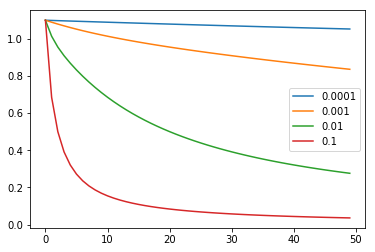

In [15]:
print(len(allCostHistory))
for ch in allCostHistory:
    print(len(allCostHistory[ch]),ch)
    plt.plot(allCostHistory[ch], label=ch)
plt.legend()
plt.show()

The plot shows that with a learning rate of 0.1, the cost converges the fastest and 0.01 is also making good progress over 5000 iterations. 0.0001 is hardly converging and 0.001 is very slow.

**Lets us now run the model on the MNIST dataset.**

We are going to cheat a little bit here and use tensorflow to load the dataset instead of writing numpy functions.

In [16]:
from tensorflow.examples.tutorials.mnist import input_data

In [17]:
mnist = input_data.read_data_sets("../datasets/MNIST/", one_hot=True)

Extracting ../datasets/MNIST/train-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/train-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/t10k-labels-idx1-ubyte.gz


The tensorflow data loader splits the 60000 images in the MNIST training set into a 55000+5000 examples where the set of 5000 is used as a validation set.

In [18]:
print(mnist.train.num_examples)
print(mnist.validation.num_examples)
print(mnist.test.num_examples)

55000
5000
10000


In [19]:
X = mnist.train.images
Y = mnist.train.labels
labels = np.argmax(Y,axis=1)
print(X.shape,Y.shape,labels.shape)

W, b = InitWeights(X, Y)
print(W.shape,b.shape)


(55000, 784) (55000, 10) (55000,)
(784, 10) (1, 10)


InitWeights sets all the weights to zero. Running Predictions with these values should predict everything to 
the "0" class. If the images are uniformly distributed over the 10 classes, we should see an accuracy value of 0.1.
Here we get a value of 0.0989 which is pretty close.

In [20]:
preds = Predictions(X, W, b)
accuracy = Accuracy(preds, labels)
print("accuracy =", accuracy)
for i in range(10):
    print(preds[10000+i],labels[10000 + i])

accuracy = 0.0989818181818
0 5
0 1
0 1
0 3
0 6
0 2
0 6
0 3
0 3
0 1


Find the best learning rate among 0.1, 1.0 and 10 by running 100 iterations of the model for each of them.

In [21]:
allCostHistory = {}
trainAccuracyHistory = {}
iterations=100
for learningRate in [0.1,1,10]:
    W, b, costHistory, trainAccuracy = TrainModel(X, Y, labels, iterations, learningRate,verbose=True)
    trainAccuracyHistory[learningRate] = trainAccuracy
    allCostHistory[learningRate] = costHistory
    print("learningRate =", learningRate)
    print("W =", W)
    print("b = ", b)
    print("cost = ", costHistory[-1])
    print("training accuracy = ", trainAccuracy)
    print("\n\n")

iteration: 0
cost = 2.30258509299
accuracy = 0.662927272727
time elapsed = 1.2999680042266846
iteration: 2
cost = 2.10085950877
accuracy = 0.722036363636
time elapsed = 3.2730071544647217
iteration: 4
cost = 1.92974130319
accuracy = 0.744636363636
time elapsed = 5.312549829483032
iteration: 6
cost = 1.78266240095
accuracy = 0.758890909091
time elapsed = 7.004565954208374
iteration: 8
cost = 1.65629941081
accuracy = 0.7708
time elapsed = 8.681689023971558
iteration: 10
cost = 1.5477180063
accuracy = 0.779636363636
time elapsed = 11.538990020751953
iteration: 12
cost = 1.45421471527
accuracy = 0.787854545455
time elapsed = 14.34181809425354
iteration: 14
cost = 1.37338850518
accuracy = 0.794654545455
time elapsed = 16.281435012817383
iteration: 16
cost = 1.30317504621
accuracy = 0.799290909091
time elapsed = 18.571620225906372
iteration: 18
cost = 1.2418386614
accuracy = 0.804636363636
time elapsed = 20.20599603652954
iteration: 20
cost = 1.18794019755
accuracy = 0.809163636364
time elap

iteration: 66
cost = 0.370434223279
accuracy = 0.897745454545
time elapsed = 80.1128191947937
iteration: 68
cost = 0.368612745242
accuracy = 0.898327272727
time elapsed = 82.13282918930054
iteration: 70
cost = 0.366863896187
accuracy = 0.899018181818
time elapsed = 84.80580806732178
iteration: 72
cost = 0.365182780429
accuracy = 0.899545454545
time elapsed = 87.81743216514587
iteration: 74
cost = 0.363564982387
accuracy = 0.899854545455
time elapsed = 91.00881099700928
iteration: 76
cost = 0.362006499217
accuracy = 0.9002
time elapsed = 93.50413799285889
iteration: 78
cost = 0.360503687548
accuracy = 0.9006
time elapsed = 96.53227019309998
iteration: 80
cost = 0.359053220075
accuracy = 0.900890909091
time elapsed = 99.38571429252625
iteration: 82
cost = 0.357652049349
accuracy = 0.901127272727
time elapsed = 102.75490927696228
iteration: 84
cost = 0.35629737704
accuracy = 0.901436363636
time elapsed = 105.77681612968445
iteration: 86
cost = 0.354986627531
accuracy = 0.901745454545
time

The plot shows that with a learning rate of 10, the cost does not go down monotonically and keep oscillating which points to it being too high. Learning rates of 0.1 and 1 show similar behaviour with 1 slight better in terms of lower cost. So we will use that for running the model for more epochs till we get good accuracy. 

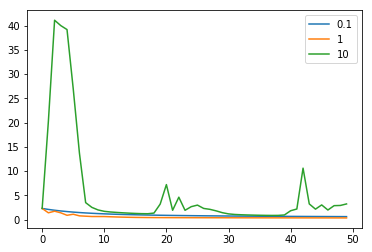

In [22]:
for ch in allCostHistory:
    plt.plot(allCostHistory[ch], label=ch)
plt.legend()
plt.show()

**Run the model for a 1000 epochs on the training set.**

iteration: 0
cost = 2.30258509299
accuracy = 0.662927272727
time elapsed = 1.7432122230529785
iteration: 20
cost = 0.630632074221
accuracy = 0.780127272727
time elapsed = 15.271590232849121
iteration: 40
cost = 0.405882711453
accuracy = 0.888181818182
time elapsed = 27.892492055892944
iteration: 60
cost = 0.376392691773
accuracy = 0.896236363636
time elapsed = 40.44439721107483
iteration: 80
cost = 0.359053220075
accuracy = 0.900890909091
time elapsed = 53.15896224975586
iteration: 100
cost = 0.346862271846
accuracy = 0.903818181818
time elapsed = 65.97528910636902
iteration: 120
cost = 0.337660104572
accuracy = 0.906363636364
time elapsed = 78.82346820831299
iteration: 140
cost = 0.33038492847
accuracy = 0.908272727273
time elapsed = 91.37506413459778
iteration: 160
cost = 0.324440572934
accuracy = 0.910127272727
time elapsed = 104.74938917160034
iteration: 180
cost = 0.319461734922
accuracy = 0.911581818182
time elapsed = 117.3792781829834
iteration: 200
cost = 0.315209988465
accurac

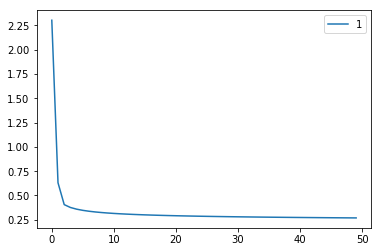

In [20]:
allCostHistory = {}
trainAccuracyHistory = {}
iterations=1000
for learningRate in [1]:
    W, b, costHistory, trainAccuracy = TrainModel(X, Y, labels, iterations, learningRate,verbose=True)
    trainAccuracyHistory[learningRate] = trainAccuracy
    allCostHistory[learningRate] = costHistory
    print("learningRate =", learningRate)
    print("W =", W)
    print("b = ", b)
    print("cost = ", costHistory[-1])
    print("training accuracy = ", trainAccuracy)
    print("\n\n")
for ch in allCostHistory:
    plt.plot(allCostHistory[ch], label=ch)
plt.legend()
plt.show()

The training accuracy got to around 92.5% and is making very small improvements after that. The training accuracy hit 91.6% after 300 epochs and hit 92% after 460 epoch for comparison. It took 659.55 sec to run the model for a 1000 epochs.

Lets look at a few predictions and try to find a misprediction.

In [25]:
preds = Predictions(X, W, b)
accuracy = Accuracy(preds, labels)
print("training accuracy =", accuracy)
for i in range(10):
    print("prediction =",preds[30020+i],"label =",labels[30020 + i])

training accuracy = 0.925581818182
prediction = 2 label = 2
prediction = 8 label = 8
prediction = 3 label = 3
prediction = 2 label = 2
prediction = 9 label = 9
prediction = 8 label = 8
prediction = 4 label = 6
prediction = 6 label = 6
prediction = 0 label = 0
prediction = 5 label = 5


Training example 30026 was incorrectly classified as a "4" instead of a "6". Looking at the image shows why the classifier might have gotten it wrong. Example 30027 which was correctly classied as "6" is much easier to classify.

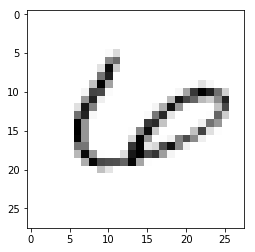

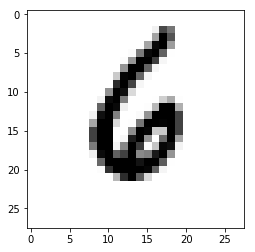

In [26]:
plt.imshow(mnist.train.images[30026].reshape(28,28),cmap="Greys")
plt.show()
plt.imshow(mnist.train.images[30027].reshape(28,28),cmap="Greys")
plt.show()

Compute the accuracy of predictions on the validation and test sets.

In [27]:
XV = mnist.validation.images
YV = mnist.validation.labels
labelsV = np.argmax(YV,axis=1)
predsV = Predictions(XV, W, b)
accuracyV = Accuracy(predsV, labelsV)
print("validation accuracy =", accuracyV)

validation accuracy = 0.9274


In [28]:
XT = mnist.test.images
YT = mnist.test.labels
labelsT = np.argmax(YT,axis=1)
predsT = Predictions(XT, W, b)
accuracyT = Accuracy(predsT, labelsT)
print("Test accuracy =", accuracyT)

Test accuracy = 0.9228


The validation and test accuracy values are pretty close to the training accuracy which indicates that there was no overfitting. It is possible that running the model longer could improve the accuracy but at a very slow rate and does not seem worthwhile.

We did achieve the same accuracy as the TensorFlow SoftMax tutorial except that it took 200X the time and number of epochs to get there.

The next step will be to implement mini batch gradient descent to move towards the minima faster with fewer epochs.